In [14]:
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, root_mean_squared_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

**Load**

In [15]:
df = pd.read_csv('test_tinsa_data.csv', delimiter=';')

Preview

In [16]:
df.head()

,TIPOLOGIA,FECHA,VALOR,SUPERFICIE,DORMITORIOS,BANNOS,ANTIGUEDAD,ASCENSOR,EXTERIOR_INTERIOR,LONGITUD,LATITUD,CODPOS,CODMUN
0,PLURIFAMILIAR,2022-01,217704,111,3,2,1,si,INTERIOR,"-4,51674","36,6709",29140,29067
1,PLURIFAMILIAR,2022-01,161268,90,3,2,56,si,EXTERIOR,"-4,35973","36,72343",29017,29067
2,PLURIFAMILIAR,2022-08,250035,115,3,2,33,si,EXTERIOR,"-4,41427","36,73288",29013,29067
3,PLURIFAMILIAR,2022-08,335381,144,4,2,47,si,EXTERIOR,"-4,4382","36,7165",29006,29067
4,PLURIFAMILIAR,2022-01,353266,154,4,2,47,si,EXTERIOR,"-4,43478","36,71886",29007,29067


Set Up

In [17]:

df['CODPOS'] = df['CODPOS'].astype(str)
df['CODMUN'] = df['CODMUN'].astype(str)
df['LONGITUD'] = df['LONGITUD'].str.replace(',', '.').astype(float)
df['LATITUD'] = df['LATITUD'].str.replace(',', '.').astype(float)
df['PRECIO_M2'] = df['VALOR'] / df['SUPERFICIE']
df['FECHA'] = pd.to_datetime(df['FECHA'])

quantitative = [f for f in df.columns if df.dtypes[f] != 'object']
qualitative = [f for f in df.columns if df.dtypes[f] == 'object']
qualitative_encoded = pd.get_dummies(df[qualitative])

qualitative_encoded['YEAR'] = df['FECHA'].dt.year
qualitative_encoded['MOTH'] = df['FECHA'].dt.month
qualitative_encoded['DAY'] = df['FECHA'].dt.day
qualitative_encoded['DAY_OF_WEEK'] = df['FECHA'].dt.dayofweek
qualitative_encoded['IS_WEEKEND'] = (df['FECHA'].dt.dayofweek >= 5).astype(int)
qualitative_encoded['QUARTER'] = df['FECHA'].dt.quarter
qualitative_encoded['IS_MONTH_END'] = df['FECHA'].dt.is_month_end.astype(int)

quantitative.remove('FECHA')
df.drop('FECHA', axis=1, inplace=True)

X = pd.concat([df[quantitative], qualitative_encoded], axis=1).drop(['VALOR', 'PRECIO_M2'], axis=1)
y = df['VALOR']

**Exploratory Data Analysis**

In [18]:
df.describe()

,VALOR,SUPERFICIE,DORMITORIOS,BANNOS,ANTIGUEDAD,LONGITUD,LATITUD,PRECIO_M2
count,3.618000e+03,3618.000000,3618.000000,3618.000000,3618.000000,3618.000000,3618.000000,3618.000000
mean,2.367305e+05,106.369818,2.835544,1.707297,31.229961,-4.444500,36.718330,2209.253434
std,1.415540e+05,52.539410,0.868957,0.677255,23.874642,0.030973,0.016236,718.024905
min,1.700700e+04,29.000000,1.000000,1.000000,0.000000,-4.577130,36.646390,327.057692
25%,1.482312e+05,83.000000,2.000000,1.000000,12.000000,-4.464190,36.709590,1714.577724
50%,2.174820e+05,97.000000,3.000000,2.000000,29.000000,-4.441990,36.720890,2199.175376
75%,2.711520e+05,114.000000,3.000000,2.000000,49.000000,-4.427750,36.726393,2555.457688
max,1.728004e+06,1186.000000,13.000000,8.000000,212.000000,-4.304140,36.832630,5640.473684


In [19]:
df.dtypes

TIPOLOGIA             object
VALOR                  int64
SUPERFICIE             int64
DORMITORIOS            int64
BANNOS                 int64
ANTIGUEDAD             int64
ASCENSOR              object
EXTERIOR_INTERIOR     object
LONGITUD             float64
LATITUD              float64
CODPOS                object
CODMUN                object
PRECIO_M2            float64
dtype: object

In [20]:
quantitative

['VALOR',
 'SUPERFICIE',
 'DORMITORIOS',
 'BANNOS',
 'ANTIGUEDAD',
 'LONGITUD',
 'LATITUD',
 'PRECIO_M2']

In [21]:
qualitative

['TIPOLOGIA', 'ASCENSOR', 'EXTERIOR_INTERIOR', 'CODPOS', 'CODMUN']

In [22]:
df['PRECIO_M2'] = pd.to_numeric(df['PRECIO_M2'], errors='coerce')
top_postal_codes = df.groupby('CODPOS')['PRECIO_M2'].mean().sort_values(ascending=False).head(10)
top_postal_codes

CODPOS
29015    4340.079826
29016    3534.768828
29001    3475.925297
29005    3270.330230
29008    3101.367628
29012    2465.748854
29018    2438.465665
29010    2362.559618
29017    2316.488622
29002    2299.759581
Name: PRECIO_M2, dtype: float64

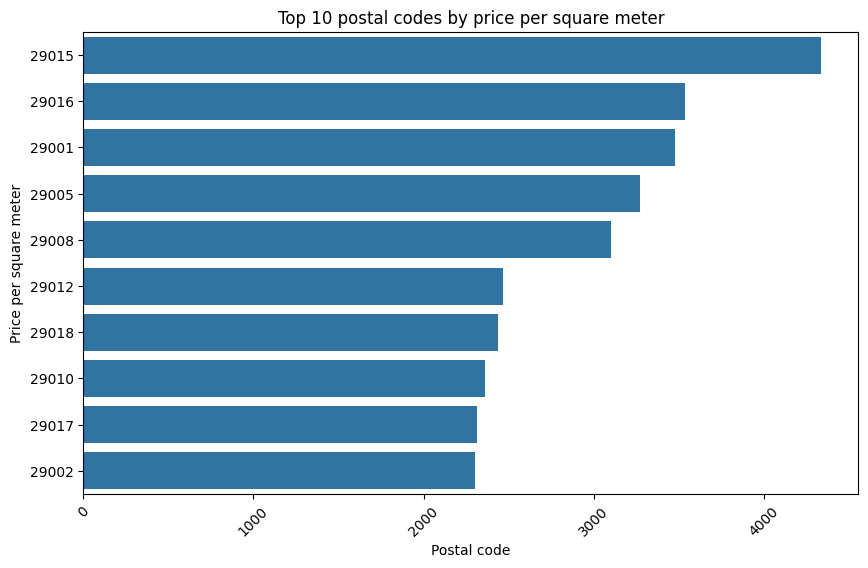

In [23]:
plt.figure(figsize=(10, 6))
sns.barplot(y=top_postal_codes.index, x=top_postal_codes.values)
plt.title('Top 10 postal codes by price per square meter')
plt.xlabel('Postal code')
plt.ylabel('Price per square meter')
plt.xticks(rotation=45)
plt.show()

/var/folders/zp/9kkn3ltx55q4wz7hp7q19ggm0000gn/T/ipykernel_33342/1427098119.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_top_postal_codes['CODPOS'] = pd.Categorical(df_top_postal_codes['CODPOS'], categories=top_postal_codes, ordered=True)
/var/folders/zp/9kkn3ltx55q4wz7hp7q19ggm0000gn/T/ipykernel_33342/1427098119.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_top_postal_codes.sort_values('CODPOS', inplace=True)


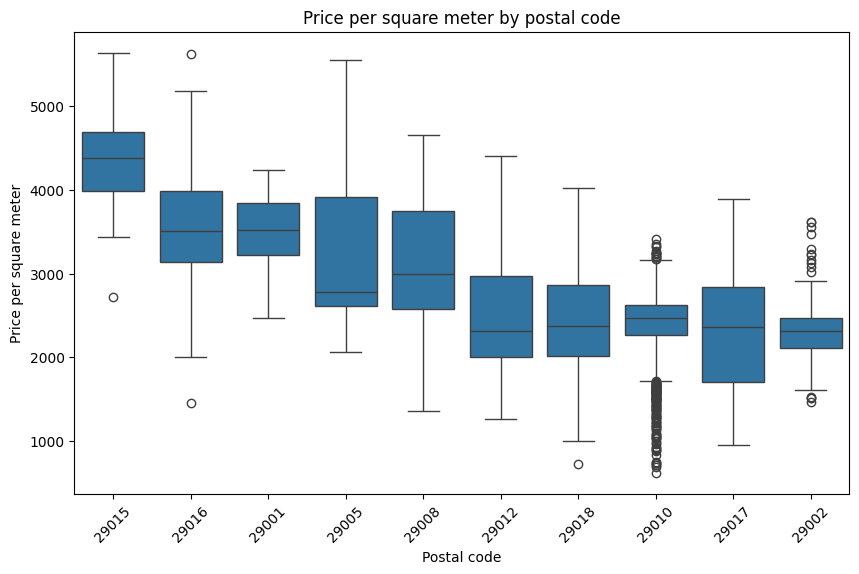

In [24]:
# Plot box plots for the top 10 postal codes in the same order as the bar plot
top_postal_codes = list(top_postal_codes.index)
df_top_postal_codes = df[df['CODPOS'].isin(top_postal_codes)]
df_top_postal_codes['CODPOS'] = pd.Categorical(df_top_postal_codes['CODPOS'], categories=top_postal_codes, ordered=True)
df_top_postal_codes.sort_values('CODPOS', inplace=True)
plt.figure(figsize=(10, 6))
sns.boxplot(x='CODPOS', y='PRECIO_M2', data=df_top_postal_codes)
plt.title('Price per square meter by postal code')
plt.xlabel('Postal code')
plt.ylabel('Price per square meter')
plt.xticks(rotation=45)
plt.show()

Podría seguirse estudiando los códigos postales 29002 y 29010 para investigar la distribución y cantidad de datos fuera del rango intercuartil.

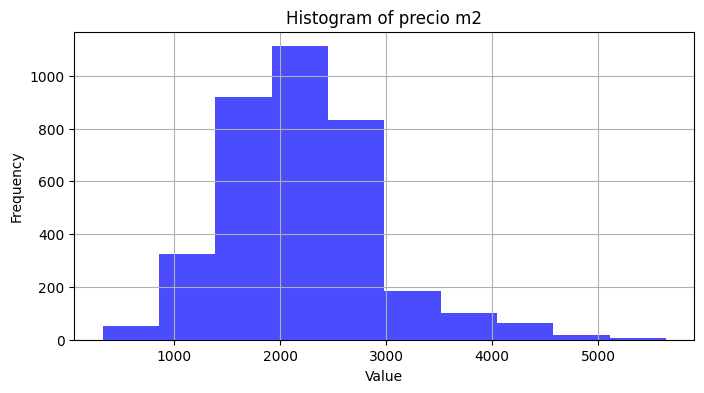

In [25]:
plt.figure(figsize=(8, 4))
plt.hist(df['PRECIO_M2'], bins=10, alpha=0.7, color='blue')
plt.title('Histogram of precio m2')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

Visualizar correlaciones entre variables.

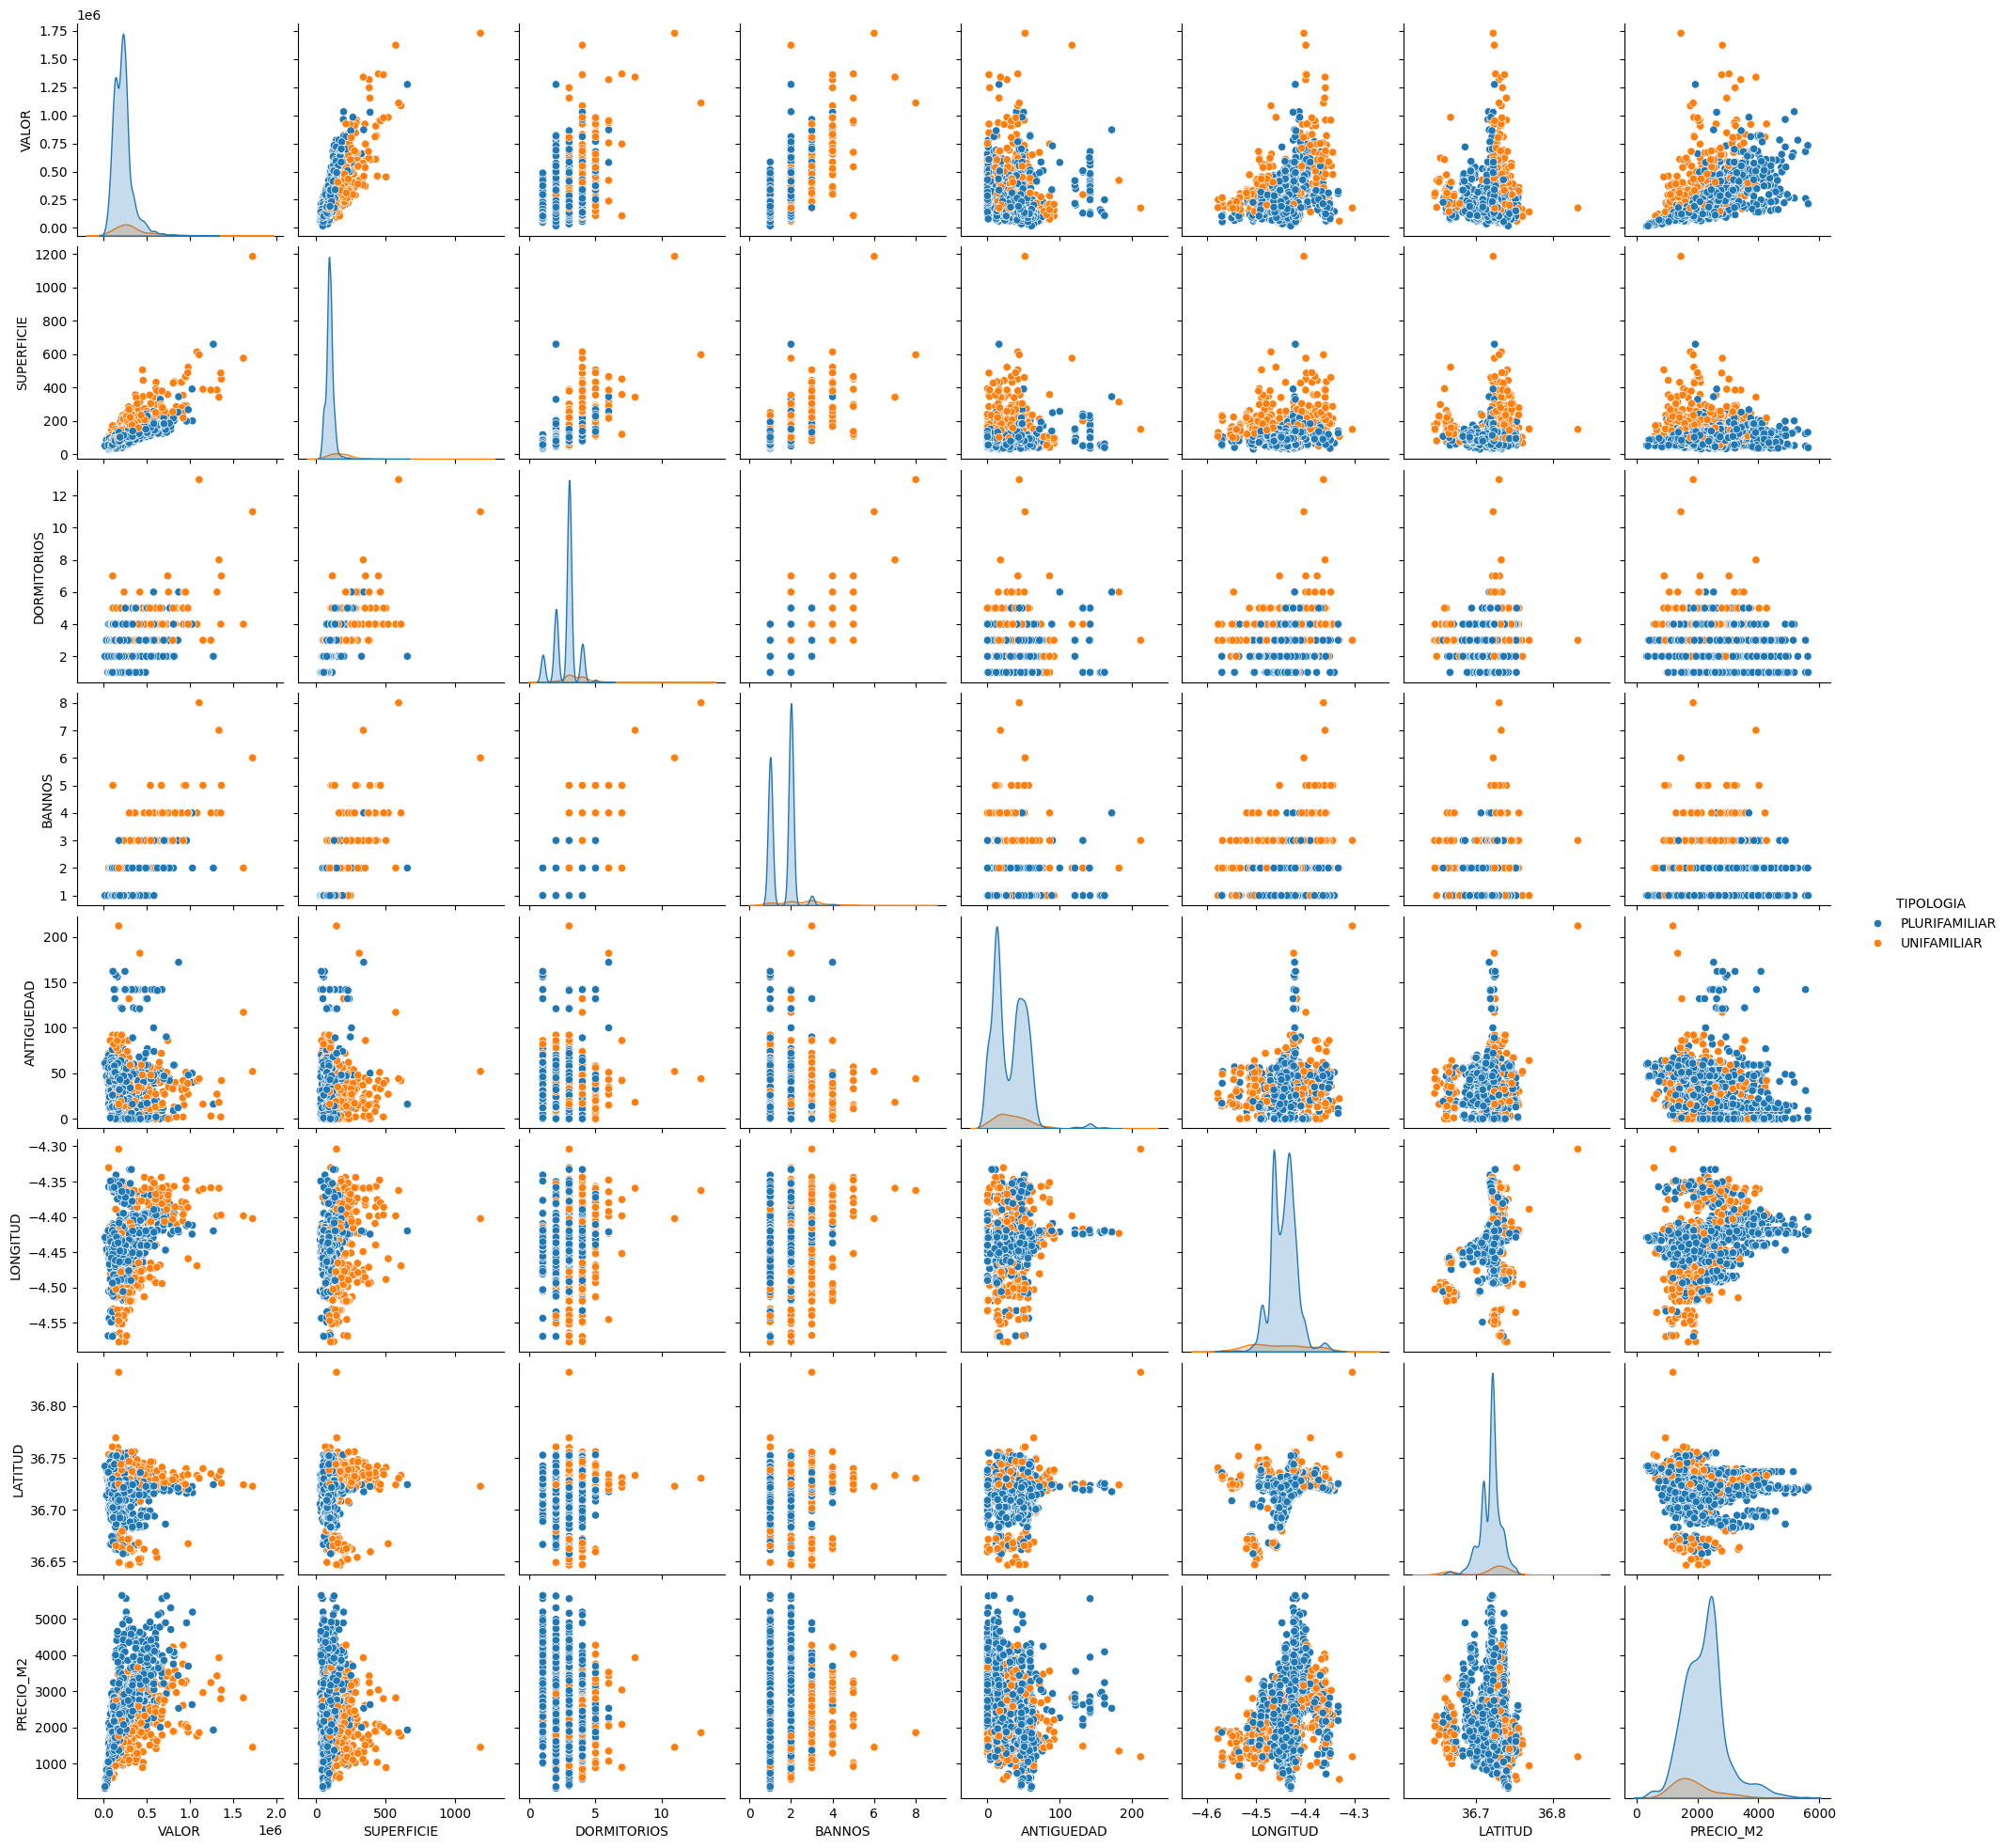

In [26]:
sns.pairplot(df[quantitative+['TIPOLOGIA']], hue="TIPOLOGIA")

En esta visualización podemos ver las correlaciones entre las distintas variables cuantitativas. 

/Users/carlosfiestas/Documents/code/test_tinsa_data/.venv/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/carlosfiestas/Documents/code/test_tinsa_data/.venv/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


<Axes: >

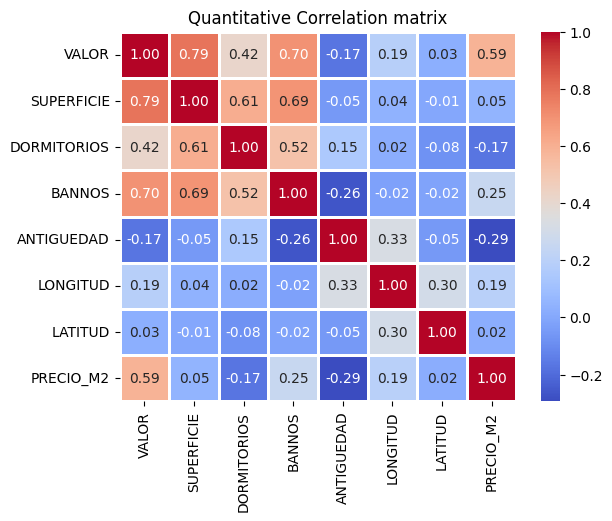

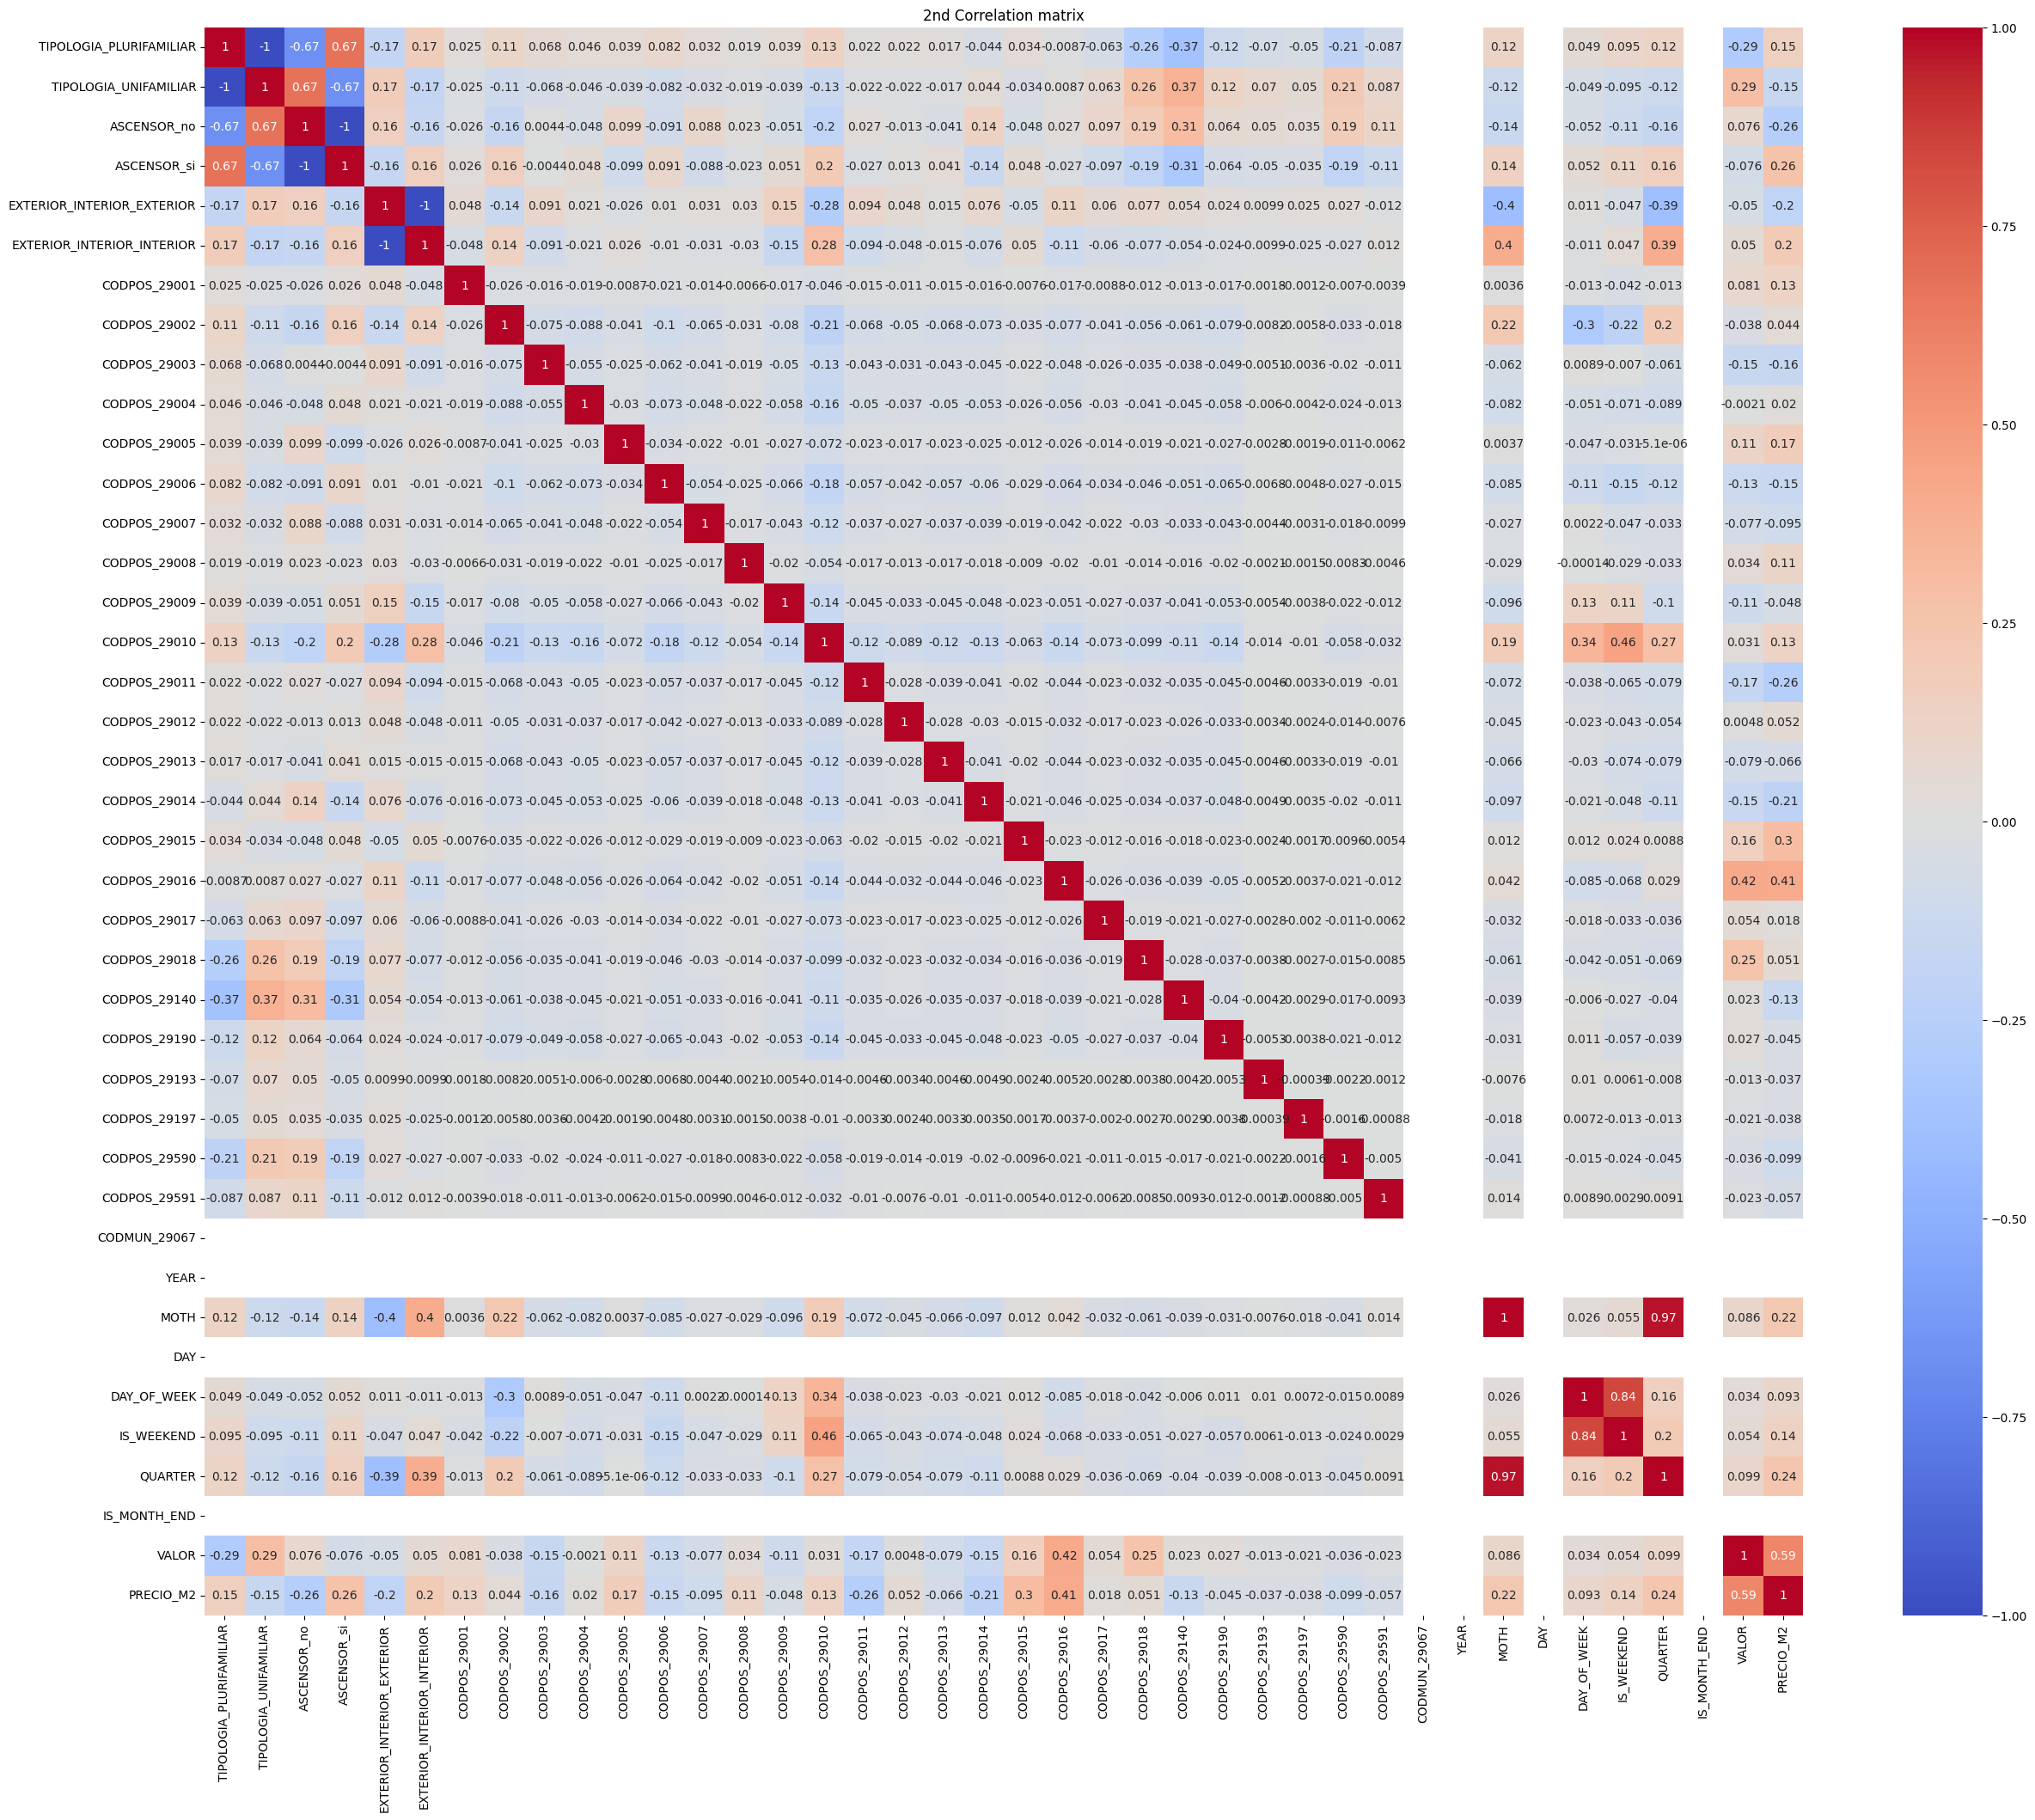

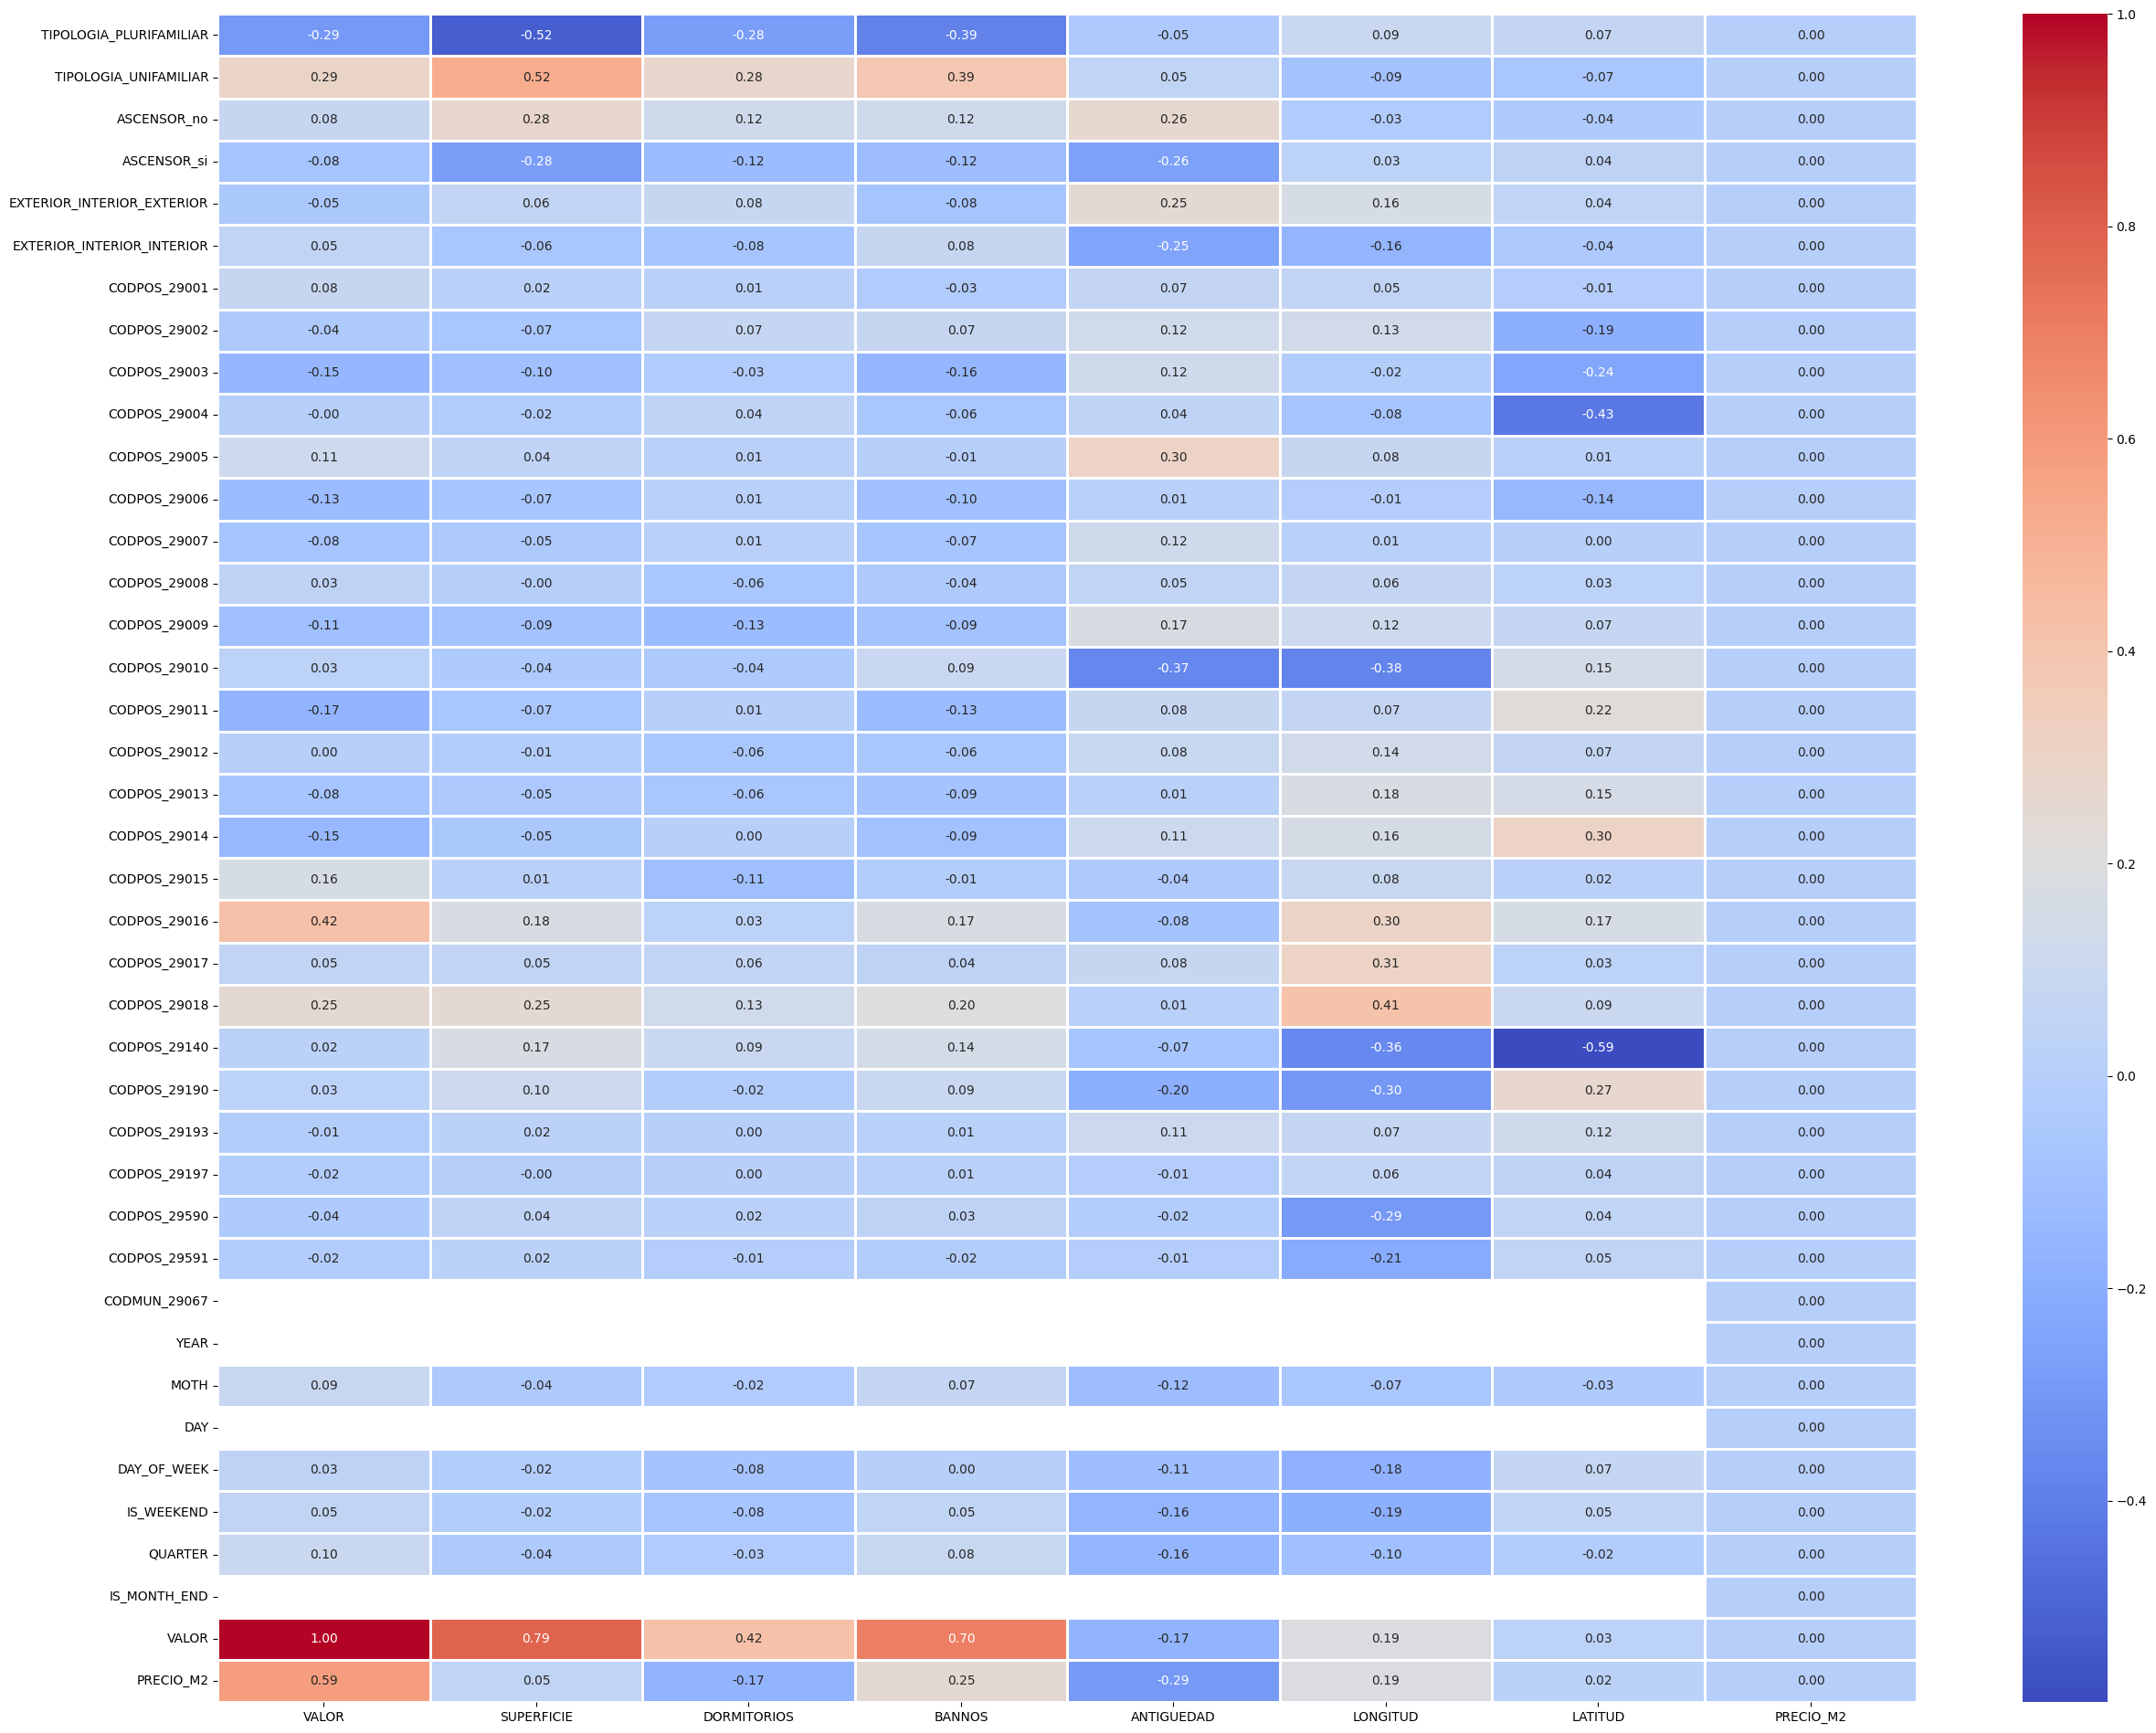

In [27]:
plt.figure(1)
corr = df[quantitative].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=2)
plt.title('Quantitative Correlation matrix')

plt.figure(2, figsize=(30, 24))
qualitative_encoded['VALOR'] = df['VALOR']
qualitative_encoded['PRECIO_M2'] = df['PRECIO_M2']
corr = qualitative_encoded.corr()
plt.title('2nd Correlation matrix')
sns.heatmap(corr, annot=True, cmap='coolwarm')

plt.figure(3, figsize=(30, 24))
corr_dict = {}
for q1 in quantitative:
    corr_dict[q1] = {}
    for q2 in qualitative_encoded.columns:
        corr_dict[q1][q2] = df[q1].corr(qualitative_encoded[q2])
corr_dict['PRECIO_M2'] = {col: 0 for col in qualitative_encoded.columns}
corr = pd.DataFrame(corr_dict)
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=2)


<Axes: xlabel='LONGITUD', ylabel='LATITUD'>

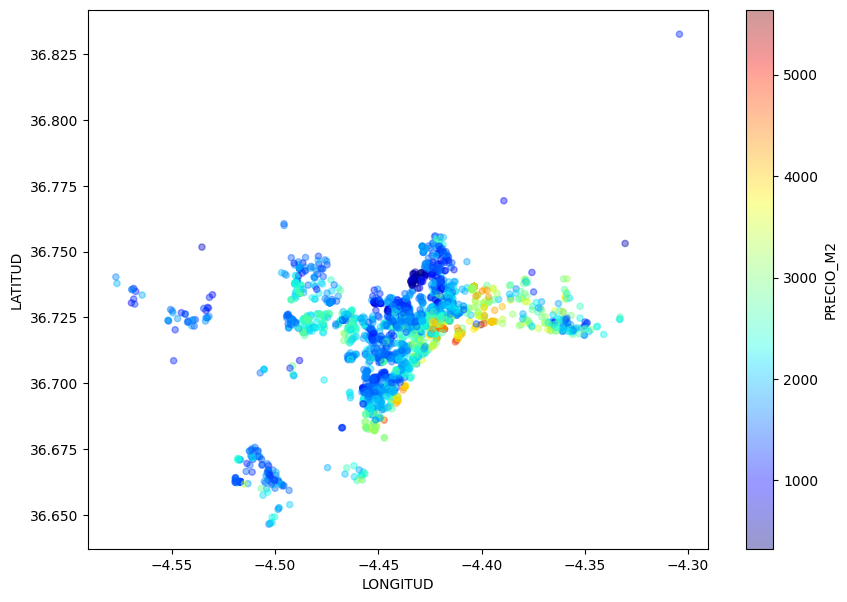

In [28]:

df.plot(kind="scatter", x="LONGITUD", y="LATITUD", alpha=0.4, figsize=(10,7),
    c="PRECIO_M2", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)

Cómo podemos observar, cerca la costa, el precio por metro cuadrado es mayor que en las afueras de **Málaga**.

**Predictions**

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Feature Engineering

In [30]:
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_poly)
X_test_scaled = scaler.transform(X_test_poly)

Multi linear regression

In [31]:
linear_model = LinearRegression()
linear_model.fit(X_train_scaled, y_train)
y_pred = linear_model.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
print("Linear Regression")
print("------------------")
print('MSE: ', mse)
print('RMSE: ', rmse)
print('Intercept: ', linear_model.intercept_)
print('Coefficients: ', linear_model.coef_)

Linear Regression
------------------
MSE:  5.129846612182743e+33
RMSE:  7.1622947525096616e+16
Intercept:  -309944.60098990134
Coefficients:  [ 2.32608299e+17 -1.18657930e+17 -7.19125134e+16 ... -9.59373517e+14
  0.00000000e+00  0.00000000e+00]


Random Forest Regression

In [32]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)
y_pred = rf_model.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
print("\nRandom Forest")
print("------------------")
print('MSE: ', mse)
print('RMSE: ', rmse)


Random Forest
------------------
MSE:  3341947775.942933
RMSE:  57809.5820426245


Lasso Regression

In [33]:
lasso_model = Lasso(alpha=0.1, random_state=42)
lasso_model.fit(X_train, y_train)
y_pred = lasso_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
print("\nLasso")
print("------------------")
print('MSE: ', mse)
print('RMSE: ', rmse)
print('\nIntercept: ', lasso_model.intercept_)
print('Coefficients: ', lasso_model.coef_)


Lasso
------------------
MSE:  3659637396.6182976
RMSE:  60494.936950279545

Intercept:  72227123.21971288
Coefficients:  [ 1.52143528e+03 -4.35457219e+03  5.30944945e+04 -4.70612620e+02
  2.31262740e+05 -1.93925353e+06  4.69906220e+03 -2.41896399e-10
 -2.00701035e+04  4.58822341e-10 -8.37807323e+03  7.38008135e-10
  1.46271353e+05 -3.47120991e+04 -6.93228217e+04 -4.05697380e+04
  1.39436118e+05 -5.39880007e+04 -2.20078321e+04  7.04094189e+04
 -1.92405288e+04 -1.04706928e+04 -3.77628924e+04  3.56486097e+04
 -1.46076970e+04 -1.43007697e+04  1.97435974e+05  1.74844103e+05
  2.27952458e+04  6.52618715e+04 -1.67004500e+05 -1.86166760e+03
  4.07218563e+04 -1.41723709e+05 -4.90336561e+04 -5.68059888e+04
  0.00000000e+00  0.00000000e+00 -1.18106834e+03  0.00000000e+00
  5.97466039e+03 -6.79117711e+03  7.96347824e+03  0.00000000e+00]


/Users/carlosfiestas/Documents/code/test_tinsa_data/.venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.342e+10, tolerance: 5.612e+09
  model = cd_fast.enet_coordinate_descent(


Random Forest Hyperparameter Tuning Using Grid Search

In [ ]:
# Hyper parameter tuning
parameters = {
        'max_depth': [15],
        'n_estimators': [300, 500, 700, 1000],
}

grid_search = GridSearchCV(rf_model, parameters, cv=5, scoring='neg_root_mean_squared_error')   
grid_search.fit(X_train_scaled, y_train)
print("\nRandom Forest Grid Search")
print("------------------------------")
print('--> Best parameters: ', grid_search.best_params_)
print('--> Best RMSE ', grid_search.best_score_)

Visualización de uno de los árboles de decisión de random forest

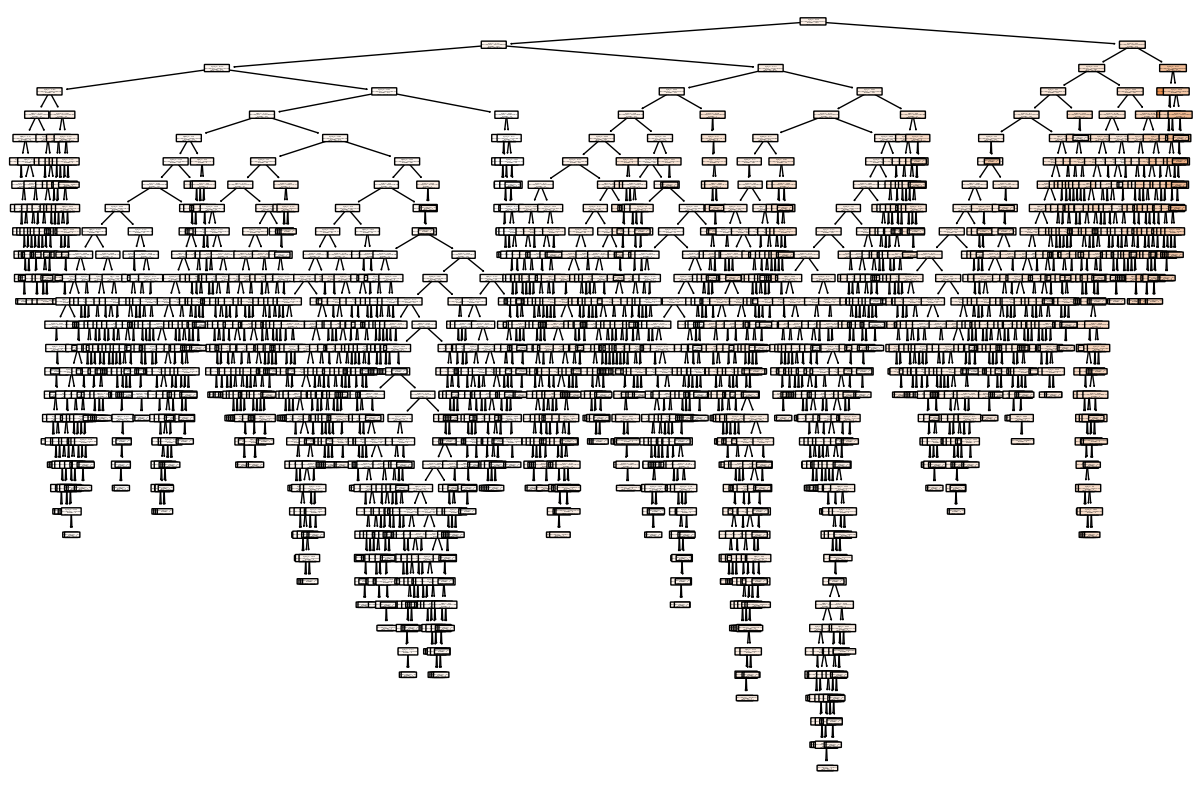

In [69]:
estimator = rf_model.estimators_[8]

plt.figure(figsize=(15, 10))
plot_tree(estimator, filled=True, rounded=True)
plt.show()

De este algoritmo, podemos extraer las variables que más influyen en la predicción final del modelo.

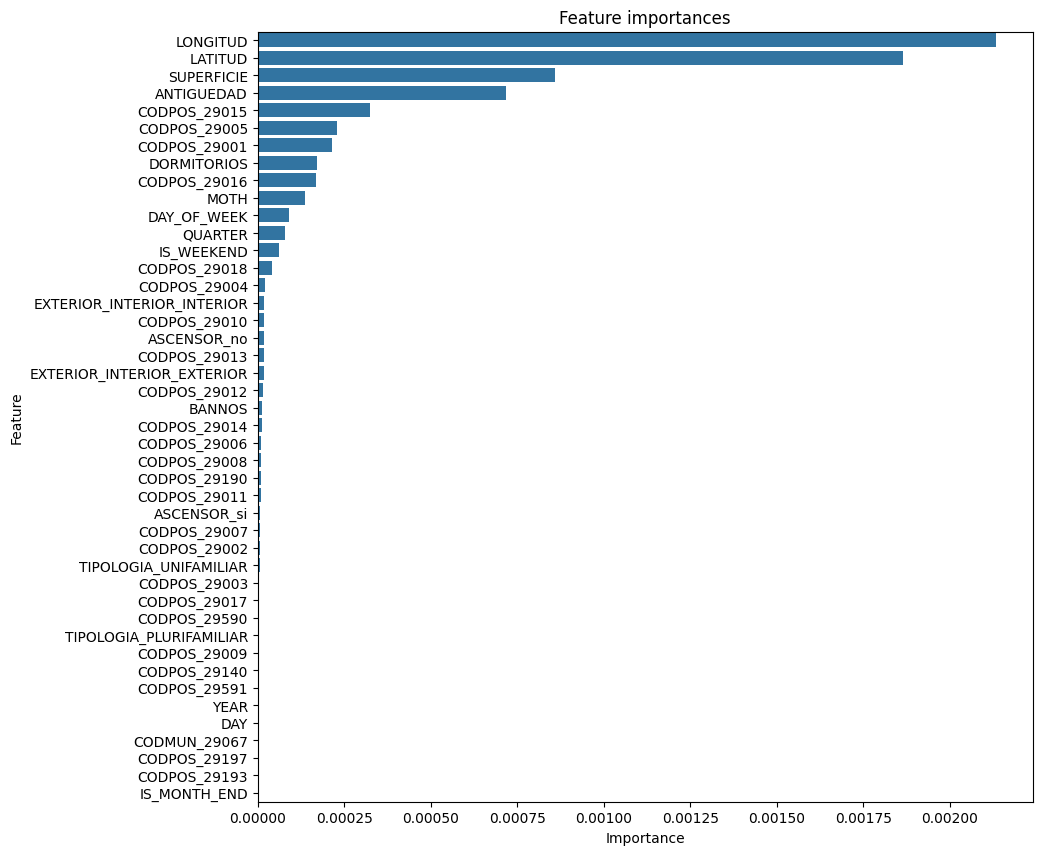

In [67]:
feature_importances = rf_model.feature_importances_

importance_df = pd.DataFrame(zip(X_train.columns, feature_importances), columns=['Feature', 'Importance'])
importance_df.set_index('Feature', inplace=True)
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=importance_df['Importance'], y=importance_df.index)
plt.title('Feature importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

La localización de la vivienda, junto con la superficie y la antiguedad, son las variables que más influyen en la predicción final.

In [85]:
results = grid_search.cv_results_
params = results['params']
mean_test_scores = results['mean_test_score']
std_test_scores = results['std_test_score']

print("\nRandom Forest Grid Search Results")
print("-------------------------------------")
for param, mean_score, std_score in zip(params, mean_test_scores, std_test_scores):
    print(f"Parameters: {param}, Mean RMSE: {-mean_score}, Std RMSE: {std_score}")



Random Forest Grid Search Results
-------------------------------------
Parameters: {'max_depth': 3, 'n_estimators': 300}, Mean RMSE: 71824.91631545608, Std RMSE: 3167.6051889823484
Parameters: {'max_depth': 3, 'n_estimators': 500}, Mean RMSE: 71803.26049871779, Std RMSE: 3243.3433976093515
Parameters: {'max_depth': 3, 'n_estimators': 700}, Mean RMSE: 71820.44294474923, Std RMSE: 3304.2528876638944
Parameters: {'max_depth': 3, 'n_estimators': 1000}, Mean RMSE: 71741.80591682652, Std RMSE: 3297.8327319226605
Parameters: {'max_depth': 5, 'n_estimators': 300}, Mean RMSE: 60590.397138369175, Std RMSE: 4049.815094487415
Parameters: {'max_depth': 5, 'n_estimators': 500}, Mean RMSE: 60505.04828448859, Std RMSE: 4036.9912060985453
Parameters: {'max_depth': 5, 'n_estimators': 700}, Mean RMSE: 60548.800590027764, Std RMSE: 4079.037378897413
Parameters: {'max_depth': 5, 'n_estimators': 1000}, Mean RMSE: 60538.61402945304, Std RMSE: 4141.96313375227
Parameters: {'max_depth': 7, 'n_estimators': 30

Podemos observar que los mejores parámetros para random forest son los siguientes:

**max_depth: 15, n_estimators: 500** (RMSE: 50749.26045514025)